# Aprendizagem supervisionada: analisando adoções de cachorros em abrigos de animais

Neste projeto iremos testar alguns algoritmos de aprendizagem supervisionada para prever adoções de cachorros utilizando um [dataset](https://data.sonomacounty.ca.gov/Government/Animal-Shelter-Intake-and-Outcome/924a-vesw) disponibilizado pela SoCoData, um portal de dados para o condado de Sonoma, Califórnia, Estados Unidos, atualizado em 7 de julho de 2020. O dataset contém informações sobre animais abrigados em casas para este fim na região do condado de Sonoma. Nosso principal objetivo é prever quanto tempo um cahcorro leva para ser adotado, desde que foi abrigado até o momento de sua adoção.

Mais informações sobre a SoCoData poderão ser encontradas [aqui](https://data.sonomacounty.ca.gov).

## Explorando os dados

Vamos começar importando as bibliotecas necessárias para ler e visualizar o dataset.

In [1]:
import numpy as np
import pandas as pd
import time

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('data/Animal_Shelter_Intake_and_Outcome.csv')
display(data.head(3))

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,SKY,DOG,GERM SHEPHERD,BLACK/TAN,Female,MED,NaN,K20-035118,DS69,A395686,...,FIELD,RETURN TO OWNER,OVER THE COUNTER_CALL,HEALTHY,HEALTHY,COUNTY,COUNTY,95404.0,"95404(38.458384, -122.675588)",1
1,COCO,DOG,BEAGLE,TRICOLOR,Neutered,SMALL,04/06/2015,K17-025093,DS83,A379968,...,FIELD,TRANSFER,NC AN FRND,UNKNOWN,HEALTHY,SANTA ROSA,OUT OF COUNTY,95758.0,"95758(38.424655, -121.438065)",1
2,SUZIE,DOG,LABRADOR RETR/MIX,BLACK,Spayed,LARGE,01/23/2011,K15-012348,DA34,A315553,...,OVER THE COUNTER,ADOPTION,INTERNET,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95404.0,"95404(38.458384, -122.675588)",1


É possível perceber que a grande maioria das variáveis são do tipo categórico. Também é perceptível que, na variável "Type", existe mais de um tipo de animal, como observado abaixo.

In [2]:
print(data["Type"].unique())

['DOG' 'CAT' 'OTHER']


Neste projeto, iremos nos focar em cachorros, então realizaremos esta seleção e iremos observar algumas variáveis de interesse.

In [3]:
data_dog = data[data["Type"] == 'DOG']
data_dog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11093 entries, 0 to 19626
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  10015 non-null  object 
 1   Type                  11093 non-null  object 
 2   Breed                 11093 non-null  object 
 3   Color                 11093 non-null  object 
 4   Sex                   11093 non-null  object 
 5   Size                  11064 non-null  object 
 6   Date Of Birth         9289 non-null   object 
 7   Impound Number        11093 non-null  object 
 8   Kennel Number         11090 non-null  object 
 9   Animal ID             11093 non-null  object 
 10  Intake Date           11093 non-null  object 
 11  Outcome Date          11031 non-null  object 
 12  Days in Shelter       11093 non-null  int64  
 13  Intake Type           11093 non-null  object 
 14  Intake Subtype        11093 non-null  object 
 15  Outcome Type       

In [4]:
print('Numero de observações: {}'.format(len(data_dog)))
print('Média de dias que um cachorro passa no abrigo: {:.1f}'.format(data_dog['Days in Shelter'].mean()))
print('Tempo mais longo de um cachorro no abrigo: {} dias'.format(data_dog['Days in Shelter'].max()))

Numero de observações: 11093
Média de dias que um cachorro passa no abrigo: 16.9
Tempo mais longo de um cachorro no abrigo: 891 dias


Podemos observar também como estão distribuídas as raças de cada cachorro.

In [5]:
n_mix_breeds = len(data_dog[data_dog['Breed'].str.contains("/")])
n_pure_breeds = len(data_dog) - n_mix_breeds

print('Cães de raça mestiça: {}'.format(n_mix_breeds))
print('Cães de raça pura: {}'.format(n_pure_breeds))


Cães de raça mestiça: 5021
Cães de raça pura: 6072


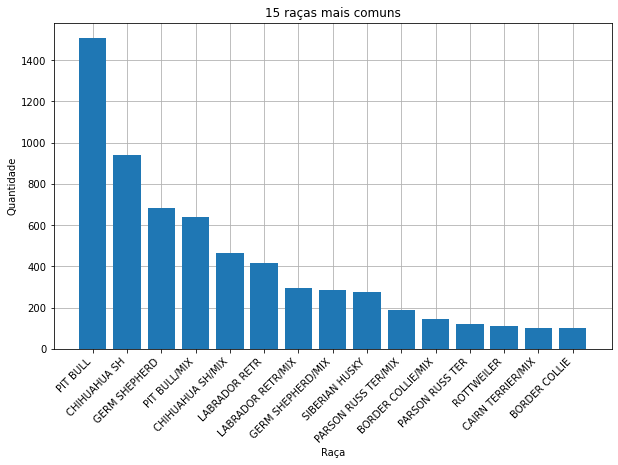

In [6]:
most_common_breeds = data_dog['Breed'].value_counts()[:15]

plt.figure(figsize=(10, 6))
x = most_common_breeds.index
y = most_common_breeds

plt.bar(x, y, zorder=3)
plt.title('15 raças mais comuns')
plt.xlabel('Raça')
plt.xticks(rotation='45', ha='right')
plt.ylabel('Quantidade')
plt.grid()
plt.show()


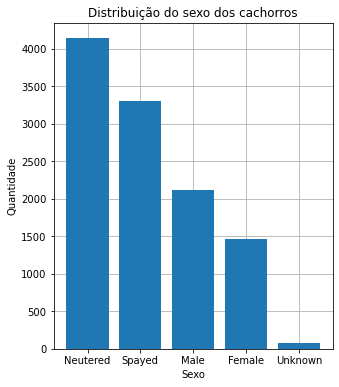

In [7]:
dog_sex = data_dog['Sex'].value_counts()

plt.figure(figsize=(5, 6))
x = dog_sex.index
y = dog_sex
plt.bar(x, y, zorder=3)
plt.title('Distribuição do sexo dos cachorros')
plt.xlabel('Sexo')
plt.ylabel('Quantidade')
plt.grid()
plt.show()

É interessante esclarecer a diferença entre 'Neutered' e 'Spayed'. Apesar de ambos se referirem à castração ou esterilização dos animais, os termos se diferenciam no que diz respeito ao processo de como é feita. O termo 'neutered' é utilizado para denominar o processo em que cães machos tiveram seus testículos removidos. Já 'spayed' refere-se ao processo em que cães fêmeas que foram esterlizadas removendo o útero e os ovários.

A castração pode parecer cruel, mas, na verdade traz muitos benefícios ao próprio animal e ao seu dono, dentre eles:
- redução na população de animais abandonados
- facilidade na manutenção da saúde do animal e redução de custos com veterinário
- redução de problemas referentes ao comportamento do animal

Mais informações podem ser vistas neste [artigo](https://www.ccspca.com/blog-spca/education/importance-of-spaying-and-neutering).

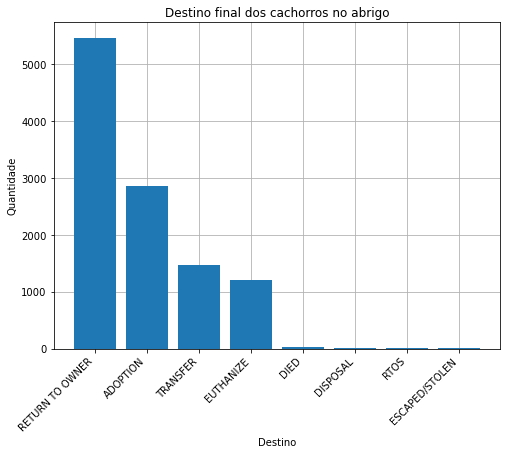

In [8]:
outcomes = data_dog['Outcome Type'].value_counts()

plt.figure(figsize=(8, 6))
x = outcomes.index
y = outcomes
plt.bar(x, y, zorder=3)
plt.xticks(rotation='45', ha='right')
plt.title('Destino final dos cachorros no abrigo')
plt.xlabel('Destino')
plt.ylabel('Quantidade')
plt.grid()
plt.show()

## Preparando os dados

### Dados vazios ou nulos

In [9]:
data_dog = data_dog[data_dog['Outcome Type'] == 'ADOPTION']

In [10]:
data_dog.isna().sum()

Name                     4
Type                     0
Breed                    0
Color                    0
Sex                      0
Size                     0
Date Of Birth           16
Impound Number           0
Kennel Number            0
Animal ID                0
Intake Date              0
Outcome Date             0
Days in Shelter          0
Intake Type              0
Intake Subtype           0
Outcome Type             0
Outcome Subtype          2
Intake Condition         0
Outcome Condition        0
Intake Jurisdiction      0
Outcome Jurisdiction    23
Outcome Zip Code         7
Location                 7
Count                    0
dtype: int64

A quantidade da valores vazios para a variável 'Size' é muito pequena quando comparada à de observações totais (menos de 1%), portanto, eles simplesmente serão retirados do dataset.

In [11]:
data_dog = data_dog.dropna(subset=['Size'])

Felizmente, poucos dados no dataset são nulos, portanto a remoção deles não fará tanta diferença nos resultados dos modelos. No entanto, há certas transformações que ainda são necessárias.

In [12]:
data_dog['Outcome Jurisdiction'].value_counts()

SANTA ROSA       989
COUNTY           763
OUT OF COUNTY    389
*WINDSOR         228
*ROHNERT PARK    165
*PETALUMA        112
*CLOVERDALE       63
*HEALDSBURG       49
*SEBASTOPOL       35
*COTATI           24
*SONOMA           15
Name: Outcome Jurisdiction, dtype: int64

### Feature engineering

Feature engineering é o processo no qual são extraídos novas features a partir dos dados brutos do próprio dataset para serem utilizadas em modelos de aprendizagem de máquina. Se feita corretamente, o resultado será um aumento na capacidade preditiva dos modelos.

Neste dataset, será criada uma nova feature: 'Year Age', que refere-se à idade que cada cachorro tinha quando foi adotado.

In [13]:
import datetime
import math

birth_dates = data_dog['Date Of Birth']
outcome_dates = data_dog['Outcome Date']

ages = []

for birth_date, outcome_date in zip(birth_dates, outcome_dates):
    if type(birth_date) == float:
        ages.append(np.nan)
    else:
        birth_month = birth_date[:2]
        birth_day = birth_date[3:5]
        birth_year = birth_date[6:]
        iso_birth = '{}-{}-{}'.format(birth_year, birth_month, birth_day)
        iso_birth_date = datetime.date.fromisoformat(iso_birth)

        outcome_month = outcome_date[:2]
        outcome_day = outcome_date[3:5]
        outcome_year = outcome_date[6:]
        iso_outcome = '{}-{}-{}'.format(outcome_year, outcome_month, outcome_day)
        iso_outcome_date = datetime.date.fromisoformat(iso_outcome)

        year_age = (iso_outcome_date - iso_birth_date).days / 365
        ages.append(math.floor(year_age))

data_dog['Year Age'] = ages

Também será criada a feature 'Is Pure' que indica se a raça de um cão é pura ou se é uma mistura.

In [14]:
isPure = []
breeds = data_dog['Breed']

for breed in breeds: 
    if '/' in breed:
        isPure.append(0)
    else:
        isPure.append(1)

data_dog['Is Pure'] = isPure

### Label encoding e One-Hot encoding

Variáveis categóricas não podem ser processadas por modelos de machine learning. Portanto, elas devem passar por um processo chamado de 'encoding', no qual são transformadas em numéricas. Duas estratégias bem conhecidas são a 'Label encoding' e a 'One-hot encoding'.

Em **label encoding**, uma variável 'v' que contenha valores 'a', 'b' e 'c' será alterada e passará a possuir os valores 0, 1 e 2 respectivamente. Isso se estenderá para todos valores presentes na variável. Deve ser utilizada com cuidado, pois o modelo pode intepretar de forma errônea que os dados aparentam estar ordenados de alguma maneira, pois 0 < 1 < 2. para isso, é utilizado em conjunto **one-hot encoding**.

Em **one-hot encoding**, cada valor da variável se tornará uma nova variável. Assim, se 'V' possui os valores 'a', 'b' e 'c', serão criadas novas variáveis de nomes 'a', 'b' e 'c' cujos valores serão 0 ou 1 de acordo coma ordem de suas entradas. Observando a tabela abaixo:

V |
---|
a |
b |
c |

Se aplicada one-hot encoding, serão criadas mais três variáveis:

a | b | c
---|---|---
1 | 0 | 0
0 | 1 | 0
0 | 0 | 1

#### Dummy variable trap

É muito comum que processos de encoding gerem uma variável desnecessária. Dada uma variável 'gênero' com valores 'feminino' e 'masculino', depois de aplicada one-hot encoding, é possível obter a seguinte configuração:

feminino | masculino
---|---
0 | 1
1 | 0
1 | 0
0 | 1

Neste caso, é possível notar que a variável 'masculino' torna-se redundante, pois possui valores exatamente contrários aos de 'feminino'. Essa dependência poderá afetar os resultados do modelo. Para resolver este, basta eliminar uma das variáveis.


Passarão pelo processo de encoding as variáveis: 'Sex', 'Size', 'Intake Type', 'Intake Condition', 'Outcome Condition', 'Breed' e 'Color'

In [15]:
data_dog_sex_encoded = pd.get_dummies(data_dog['Sex'], prefix='is').drop('is_Unknown', axis=1)
data_dog = pd.concat([data_dog, data_dog_sex_encoded], axis=1)
data_dog = data_dog.drop('Sex', axis=1)

In [16]:
data_dog['Size'].value_counts()

SMALL    802
MED      686
LARGE    528
PUPPY    436
TOY      387
X-LRG     16
Name: Size, dtype: int64

In [17]:
data_dog['Intake Type'].value_counts()

STRAY              1956
OWNER SURRENDER     529
ADOPTION RETURN     172
TRANSFER            103
CONFISCATE           85
QUARANTINE           10
Name: Intake Type, dtype: int64

In [18]:
data_dog['Intake Condition'].value_counts()

HEALTHY                 2271
TREATABLE/REHAB          279
TREATABLE/MANAGEABLE     186
UNKNOWN                  117
UNTREATABLE                2
Name: Intake Condition, dtype: int64

In [19]:
data_dog['Outcome Condition'].value_counts()

HEALTHY                 2613
TREATABLE/MANAGEABLE     120
TREATABLE/REHAB           75
PENDING                   46
UNTREATABLE                1
Name: Outcome Condition, dtype: int64

In [20]:
encoded = pd.get_dummies(data_dog[['Size', 'Intake Type', 'Intake Condition', 'Outcome Condition']], drop_first=True)
data_dog = pd.concat([data_dog, encoded], axis=1)
data_dog = data_dog.drop(['Size', 'Intake Type', 'Intake Condition', 'Outcome Condition'], axis=1)


A variável 'Breed' possui muitos valores únicos, como é mostrado abaixo.

In [22]:
len(data_dog['Breed'].value_counts())

381

Utilizar encoding para todos os valores aumentaria muito o número de variáveis tornando o modelo desnecessariamente complexo e aumentaria muito o tempo que ele levaria para ser treinado, além de não garantir precisão nos resultados. Existem várias estratégias para contornar esta situação. Neste artigo, serão encodados os 10 valores mais comuns, enquanto os outros irão ser encodados para uma outra variável 'Other_Breeds'.

In [24]:
common_breeds = data_dog['Breed'].value_counts()[:10]
common_breeds = list(common_breeds.index)

encoded_breeds = {}
for breed in common_breeds:
    encoded_breeds['is_' + str(breed)] = [1 if value == breed else 0 for value in data_dog['Breed']]

for breed in encoded_breeds.keys():
    data_dog[breed] = encoded_breeds[breed]

is_other_breeds = [0 if value in common_breeds else 1 for value in data_dog['Breed']]
data_dog['Other_Breeds'] = is_other_breeds

data_dog = data_dog.drop('Breed', axis=1)

A mesma situação ocorre para a variável 'Color', portanto, a mesma estratégia será seguida.

In [36]:
common_colors = data_dog['Color'].value_counts()[:10]
common_colors = list(common_colors.index)

encoded_colors = {}
for color in common_colors:
    encoded_colors['is_' + str(color)] = [1 if value == breed else 0 for value in data_dog['Color']]

for color in encoded_colors.keys():
    data_dog[color] = encoded_colors[color]

is_other_colors = [0 if value in common_colors else 1 for value in data_dog['Color']]
data_dog['Other_Colors'] = is_other_colors

data_dog = data_dog.drop('Color', axis=1)

Por fim, as variáveis que não irão fazer parte do modelo serão retiradas do dataset.

In [42]:
data_dog = data_dog.drop(['Name', 'Type', 'Date Of Birth', 'Impound Number', 'Kennel Number', 'Animal ID', 'Intake Date', 'Outcome Date', 'Intake Subtype', 'Outcome Type', 'Outcome Subtype', 'Intake Jurisdiction', 'Outcome Jurisdiction', 'Outcome Zip Code', 'Location', 'Count'], axis=1)

# Modelagem

Agora que o dataset está limpo, ja podem ser testados modelos. Como estamos querendo prever uma variável númerica, é preciso um modelo de regressão. A seguir, alguns modelos serão testados e terão sua peformance comparada.

- Regressão Linear Múltipla
- SVR
- Random Forest
- XGBoost